In [ ]:
! pip install librosa

In [ ]:
! pip install tensorflow

In [3]:
import os
import sys
import time
import logging

# Import Python Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import librosa library which is used to extract data and analyze audio files
import librosa
import librosa.display

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
from tqdm import tqdm

# Import sklearn libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# Import TensorFlow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model, Sequential

In [ ]:
!apt-get update
!apt-get install -y libsndfile1

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!pip install pysoundfile

## DataSets

In [ ]:
crema_d = "/content/drive/MyDrive/602/GP/CREMA-D/AudioWAV/"
tess = "/content/drive/MyDrive/602/GP/TESS/TESS_ds/"

In [ ]:
pd.set_option('display.max_colwidth', None)

### CREMA

### Load the CREMA audio files into a dataframe.

In [ ]:
crema_dir = os.listdir(crema_d)

file_emotion = []
file_path = []

emotions = {'SAD' : 'sad',
            'ANG' : 'angry',
            'DIS' : 'disgust',
            'FEA' : 'fear',
            'HAP' : 'happy',
            'NEU' : 'neutral'}

for file in crema_dir:
    # storing file paths
    file_path.append(crema_d + file)
    # storing file emotions
    part=file.split('_')
    if part[2] in emotions:
        file_emotion.append(emotions[part[2]])
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())

angry      1271
disgust    1271
fear       1271
happy      1271
sad        1271
neutral    1087
Name: Emotions, dtype: int64


### TESS

### Load the TESS data files into a Data Frame

In [ ]:
tess_directory_list = os.listdir(tess)

file_emotion = []
file_path = []

# Iterate through each directory in the TESS list
for directory in tess_directory_list:
    # Full path to the directory
    directory_path = os.path.join(tess, directory)
    # List all files within the directory
    files = os.listdir(directory_path)

    for file in files:
        # Remove the file extension and split by '_'
        parts = file.split('.')[0].split('_')

        # Ensure there are enough parts to determine the emotion
        if len(parts) >= 3:
            emotion = parts[2]
            # Map 'ps' to 'surprise' and append the result
            emotion = 'surprise' if emotion == 'ps' else emotion
            file_emotion.append(emotion)
        else:
            # Handle files without sufficient parts to determine the emotion
            file_emotion.append(None)  # Consider logging this case or handling it differently

        # Append the full path of the file
        file_path.append(os.path.join(directory_path, file))

# Create DataFrame for emotions
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Create DataFrame for file paths
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate both DataFrames horizontally
Tess_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the DataFrame
print(Tess_df.head())

# Print the count of each emotion to see the distribution
print(Tess_df.Emotions.value_counts())

  Emotions                                                      Path
0    angry  D:\UMBC\602\GP\TESS\tess_ds\OAF_angry\OAF_back_angry.wav
1    angry   D:\UMBC\602\GP\TESS\tess_ds\OAF_angry\OAF_bar_angry.wav
2    angry  D:\UMBC\602\GP\TESS\tess_ds\OAF_angry\OAF_base_angry.wav
3    angry  D:\UMBC\602\GP\TESS\tess_ds\OAF_angry\OAF_bath_angry.wav
4    angry  D:\UMBC\602\GP\TESS\tess_ds\OAF_angry\OAF_bean_angry.wav
surprise     401
angry        400
disgust      400
fear         400
happy        400
neutral      400
sad          400
surprised      1
Name: Emotions, dtype: int64


In [ ]:
Crema_df['source'] = 'CREMA-D'
Tess_df['source'] = 'TESS'

In [ ]:
# creating Dataframe using all 2 dataframes
data_path = pd.concat([Crema_df, Tess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path,source
0,angry,D:\UMBC\602\GP\CREMA-D\AudioWAV\1001_DFA_ANG_XX.wav,CREMA-D
1,disgust,D:\UMBC\602\GP\CREMA-D\AudioWAV\1001_DFA_DIS_XX.wav,CREMA-D
2,fear,D:\UMBC\602\GP\CREMA-D\AudioWAV\1001_DFA_FEA_XX.wav,CREMA-D
3,happy,D:\UMBC\602\GP\CREMA-D\AudioWAV\1001_DFA_HAP_XX.wav,CREMA-D
4,neutral,D:\UMBC\602\GP\CREMA-D\AudioWAV\1001_DFA_NEU_XX.wav,CREMA-D


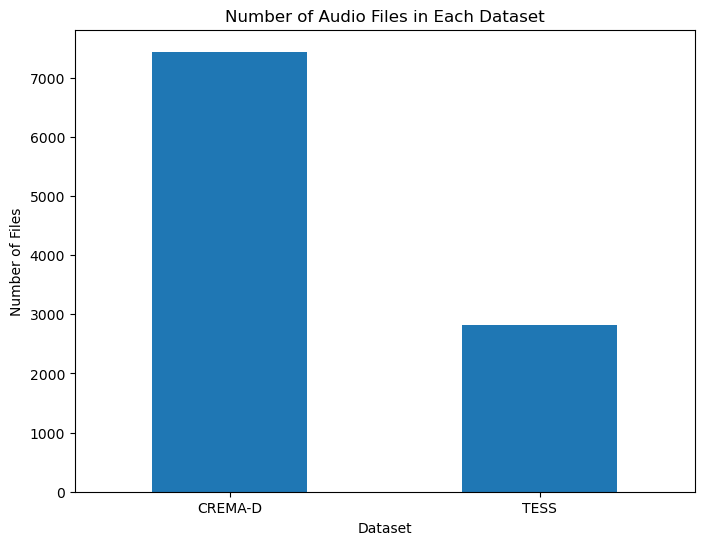

In [ ]:
# Count the number of files in each dataset
file_counts = data_path['source'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
file_counts.plot(kind='bar')
plt.title('Number of Audio Files in Each Dataset')
plt.xlabel('Dataset')
plt.ylabel('Number of Files')
plt.xticks(rotation=0)  # Rotate labels to be horizontal
plt.show()

In [ ]:
data_path.head

<bound method NDFrame.head of      Emotions                                                   Path   source
0       angry    D:\UMBC\602\GP\CREMA-D\AudioWAV\1001_DFA_ANG_XX.wav  CREMA-D
1     disgust    D:\UMBC\602\GP\CREMA-D\AudioWAV\1001_DFA_DIS_XX.wav  CREMA-D
2        fear    D:\UMBC\602\GP\CREMA-D\AudioWAV\1001_DFA_FEA_XX.wav  CREMA-D
3       happy    D:\UMBC\602\GP\CREMA-D\AudioWAV\1001_DFA_HAP_XX.wav  CREMA-D
4     neutral    D:\UMBC\602\GP\CREMA-D\AudioWAV\1001_DFA_NEU_XX.wav  CREMA-D
...       ...                                                    ...      ...
2809      sad  D:\UMBC\602\GP\TESS\tess_ds\YAF_sad\YAF_witch_sad.wav     TESS
2810      sad  D:\UMBC\602\GP\TESS\tess_ds\YAF_sad\YAF_yearn_sad.wav     TESS
2811      sad    D:\UMBC\602\GP\TESS\tess_ds\YAF_sad\YAF_yes_sad.wav     TESS
2812      sad  D:\UMBC\602\GP\TESS\tess_ds\YAF_sad\YAF_young_sad.wav     TESS
2813      sad  D:\UMBC\602\GP\TESS\tess_ds\YAF_sad\YAF_youth_sad.wav     TESS

[10256 rows x 3 columns]>

In [ ]:
data_path['Path']

0         D:\UMBC\602\GP\CREMA-D\AudioWAV\1001_DFA_ANG_XX.wav
1         D:\UMBC\602\GP\CREMA-D\AudioWAV\1001_DFA_DIS_XX.wav
2         D:\UMBC\602\GP\CREMA-D\AudioWAV\1001_DFA_FEA_XX.wav
3         D:\UMBC\602\GP\CREMA-D\AudioWAV\1001_DFA_HAP_XX.wav
4         D:\UMBC\602\GP\CREMA-D\AudioWAV\1001_DFA_NEU_XX.wav
                                ...                          
2809    D:\UMBC\602\GP\TESS\tess_ds\YAF_sad\YAF_witch_sad.wav
2810    D:\UMBC\602\GP\TESS\tess_ds\YAF_sad\YAF_yearn_sad.wav
2811      D:\UMBC\602\GP\TESS\tess_ds\YAF_sad\YAF_yes_sad.wav
2812    D:\UMBC\602\GP\TESS\tess_ds\YAF_sad\YAF_young_sad.wav
2813    D:\UMBC\602\GP\TESS\tess_ds\YAF_sad\YAF_youth_sad.wav
Name: Path, Length: 10256, dtype: object

### Displaying Data Categories

In [ ]:
# Load the dataset
data_path = "data_path.csv"
emotion_df = pd.read_csv(data_path)

# Remove rows with "Surprise" class
emotion_df = emotion_df[emotion_df['Emotions'] != 'surprise']

# Count the number of rows for each class
class_counts = emotion_df['Emotions'].value_counts()

# Remove 300 rows from each class except "happy" and "neutral"
rows_to_keep = []
for emotion, count in class_counts.items():
    if emotion in ['happy', 'neutral']:
        rows_to_keep.extend(emotion_df[emotion_df['Emotions'] == emotion].index)
    else:
        # Ensure that count - 900 is not negative
        num_to_sample = max(count - 900, 0)
        rows_to_keep.extend(emotion_df[emotion_df['Emotions'] == emotion].sample(n=num_to_sample, random_state=42).index)


# Filter the dataset to keep only the selected rows
emotion_df = emotion_df.loc[rows_to_keep]

# Check the new distribution of emotion classes
print(emotion_df['Emotions'].value_counts())

# Save the updated dataset
emotion_df.to_csv("balanced_data.csv", index=False)

happy      1671
neutral    1487
angry       771
disgust     771
fear        771
sad         771
Name: Emotions, dtype: int64


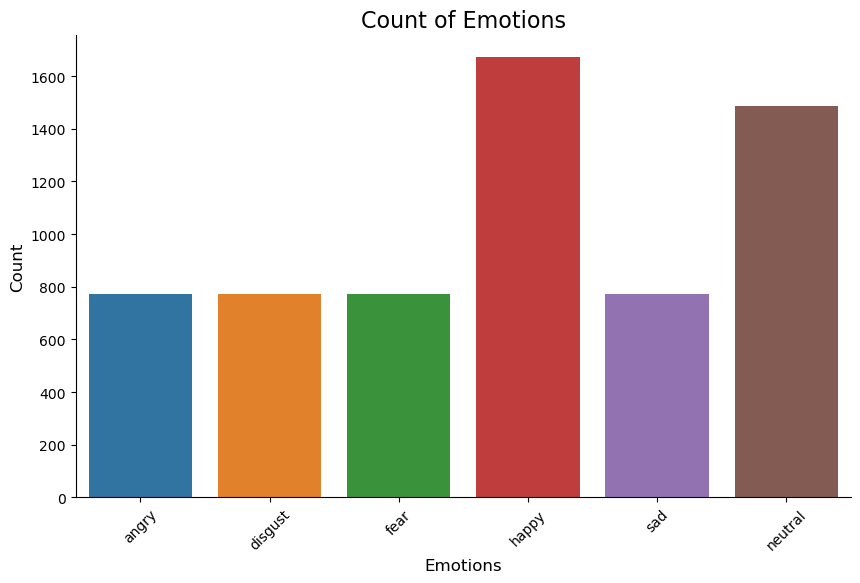

In [ ]:
data_path = "balanced_data.csv"
emotion_df = pd.read_csv(data_path)

plt.figure(figsize=(10, 6))  # Adjust the size of your plot as needed
plt.title('Count of Emotions', size=16)
sns.countplot(x=emotion_df['Emotions'])  # Ensure that 'Emotions' is the name of your column
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)  # Clean up frame visibility
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.show()


In [ ]:
# Save the updated dataset
emotion_df.to_csv("balanced_data.csv", index=False)

In [ ]:
emotion_df

,Emotions,Path,source
0,angry,D:\UMBC\602\GP\CREMA-D\AudioWAV\1032_IWL_ANG_XX.wav,CREMA-D
1,angry,D:\UMBC\602\GP\CREMA-D\AudioWAV\1041_WSI_ANG_XX.wav,CREMA-D
2,angry,D:\UMBC\602\GP\CREMA-D\AudioWAV\1041_TAI_ANG_XX.wav,CREMA-D
3,angry,D:\UMBC\602\GP\CREMA-D\AudioWAV\1039_ITH_ANG_XX.wav,CREMA-D
4,angry,D:\UMBC\602\GP\TESS\tess_ds\YAF_angry\YAF_sail_angry.wav,TESS
...,...,...,...
6237,neutral,D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_witch_neutral.wav,TESS
6238,neutral,D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_yearn_neutral.wav,TESS
6239,neutral,D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_yes_neutral.wav,TESS
6240,neutral,D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_young_neutral.wav,TESS


In [ ]:
! pip install --upgrade librosa soundfile
! pip install --upgrade librosa soundfile

  Obtaining dependency information for librosa from https://files.pythonhosted.org/packages/8c/8a/2d231b35456506b7c98b3ab9bbf07917b205fed8615d2e59e976ab497fff/librosa-0.10.2.post1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/260.1 kB ? eta -:--:--
   ---------------------------------------- 260.1/260.1 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.2
    Uninstalling librosa-0.10.2:
      Successfully uninstalled librosa-0.10.2


In [ ]:
file_path[0]

'D:\\UMBC\\602\\GP\\TESS\\tess_ds\\OAF_angry\\OAF_back_angry.wav'

In [ ]:
data,sr = librosa.load(file_path[0])
sr

22050

In [ ]:
file_path[0]

'D:\\UMBC\\602\\GP\\TESS\\tess_ds\\OAF_angry\\OAF_back_angry.wav'

In [ ]:
emotion_df

,Emotions,Path,source
0,angry,D:\UMBC\602\GP\CREMA-D\AudioWAV\1032_IWL_ANG_XX.wav,CREMA-D
1,angry,D:\UMBC\602\GP\CREMA-D\AudioWAV\1041_WSI_ANG_XX.wav,CREMA-D
2,angry,D:\UMBC\602\GP\CREMA-D\AudioWAV\1041_TAI_ANG_XX.wav,CREMA-D
3,angry,D:\UMBC\602\GP\CREMA-D\AudioWAV\1039_ITH_ANG_XX.wav,CREMA-D
4,angry,D:\UMBC\602\GP\TESS\tess_ds\YAF_angry\YAF_sail_angry.wav,TESS
...,...,...,...
6237,neutral,D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_witch_neutral.wav,TESS
6238,neutral,D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_yearn_neutral.wav,TESS
6239,neutral,D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_yes_neutral.wav,TESS
6240,neutral,D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_young_neutral.wav,TESS


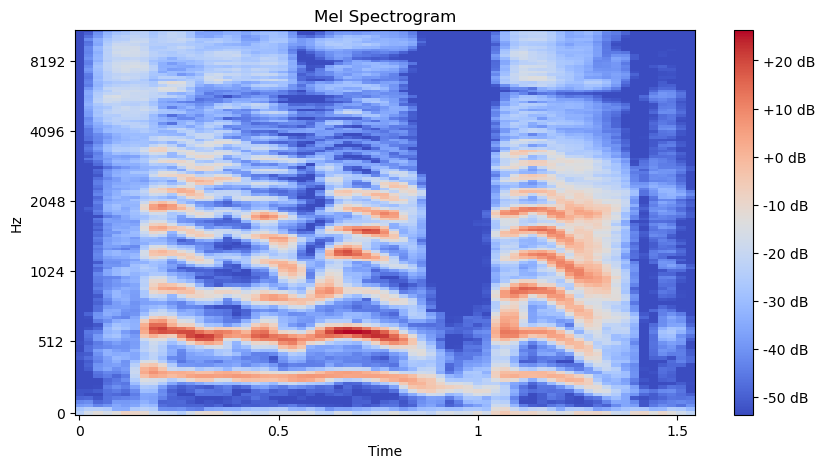

In [ ]:
# Set the dimensions for the plot
plt.figure(figsize=(10, 5))
# Compute the Mel spectrogram
n_mels = 128
fmax = 8000
mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels, fmax=fmax)

# Convert the Mel spectrogram to log scale (for better visualization)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

# Display the spectrogram
librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')

# Add a title to the plot
plt.title('Mel Spectrogram')

# Add a color bar with label formatting
plt.colorbar(format='%+2.0f dB')

# Show the plot
plt.show()

ipd.Audio(data,rate=sr)

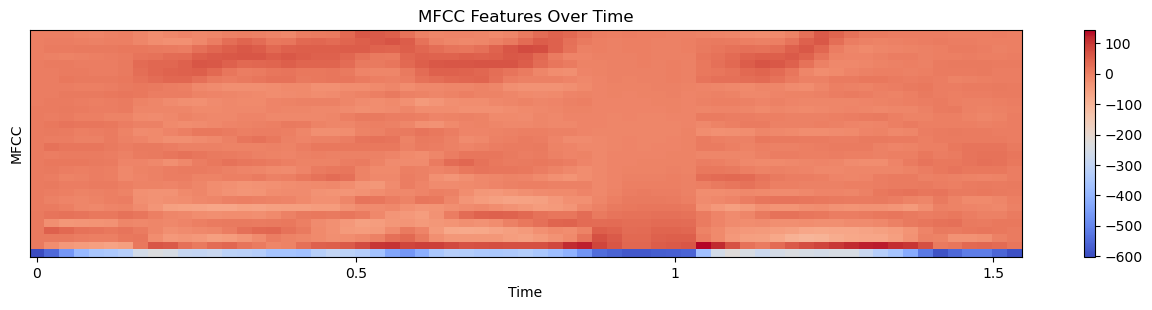

In [ ]:
# Create a plot to display the MFCC
plt.figure(figsize=(16, 10))

# Compute the MFCC (Mel Frequency Cepstral Coefficients)
n_mfcc = 30
mfcc_features = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)

# Add a subplot with specific dimensions
plt.subplot(3, 1, 1)  # (rows, columns, panel number)

# Display the MFCC using librosa's specshow function
librosa.display.specshow(mfcc_features, sr=sr, x_axis='time')

# Label the y-axis as 'MFCC'
plt.ylabel('MFCC')

# Add a colorbar to show the scale
plt.colorbar()

plt.title('MFCC Features Over Time')

# Display the plot
plt.show()

ipd.Audio(data,rate=sr)

### Data Augmentation

In [ ]:
def noise(data):
    noise_amplitude = 0.035 * np.random.uniform() * np.amax(data)
    noise = noise_amplitude * np.random.normal(size=data.shape[0])
    return data + noise

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [ ]:
emotion_df

,Emotions,Path,source
0,angry,D:\UMBC\602\GP\CREMA-D\AudioWAV\1032_IWL_ANG_XX.wav,CREMA-D
1,angry,D:\UMBC\602\GP\CREMA-D\AudioWAV\1041_WSI_ANG_XX.wav,CREMA-D
2,angry,D:\UMBC\602\GP\CREMA-D\AudioWAV\1041_TAI_ANG_XX.wav,CREMA-D
3,angry,D:\UMBC\602\GP\CREMA-D\AudioWAV\1039_ITH_ANG_XX.wav,CREMA-D
4,angry,D:\UMBC\602\GP\TESS\tess_ds\YAF_angry\YAF_sail_angry.wav,TESS
...,...,...,...
6237,neutral,D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_witch_neutral.wav,TESS
6238,neutral,D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_yearn_neutral.wav,TESS
6239,neutral,D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_yes_neutral.wav,TESS
6240,neutral,D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_young_neutral.wav,TESS


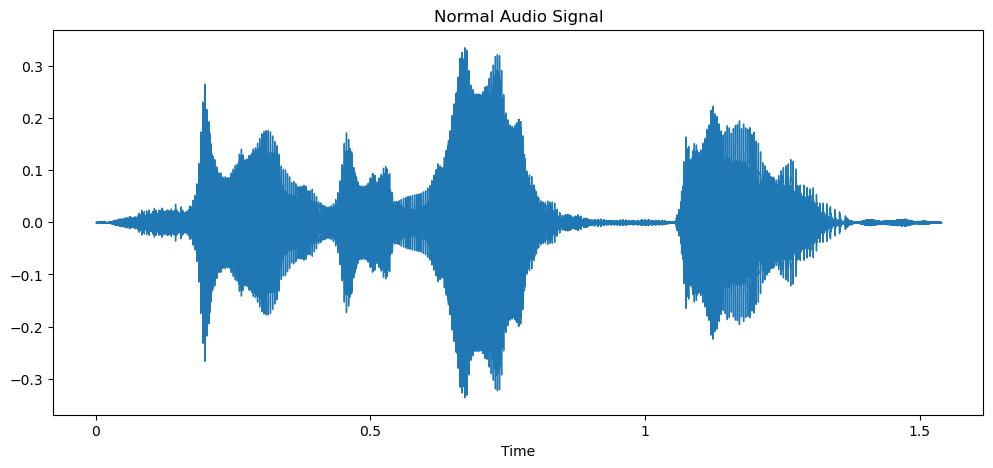

In [ ]:
# NORMAL AUDIO
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
plt.title("Normal Audio Signal")
ipd.Audio(data,rate=sr)

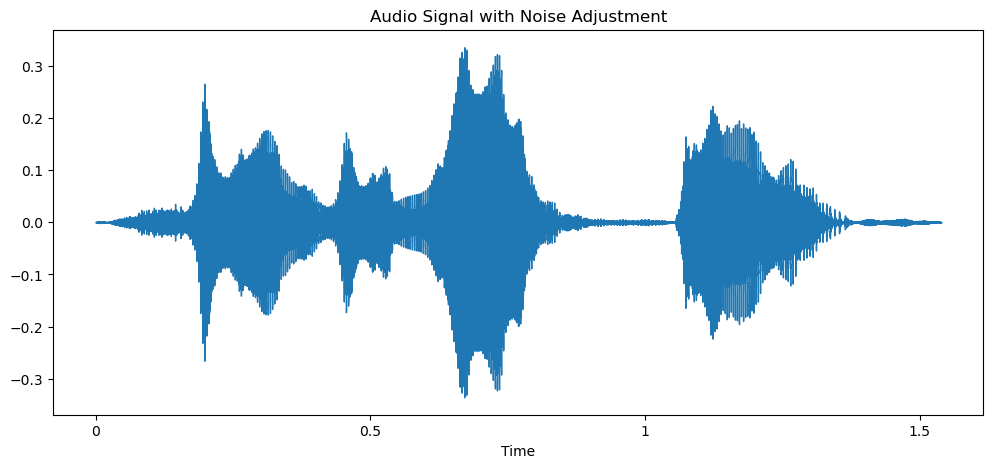

In [ ]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
plt.title("Audio Signal with Noise")
ipd.Audio(x, rate=sr)

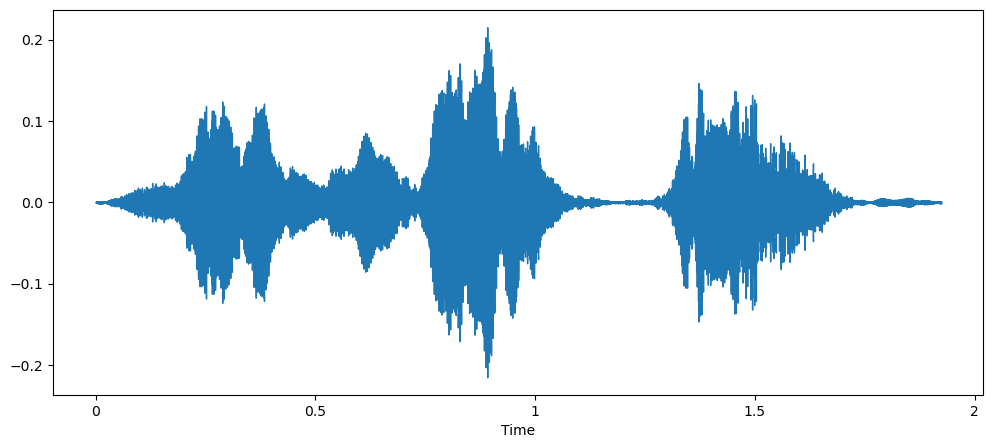

In [ ]:
# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

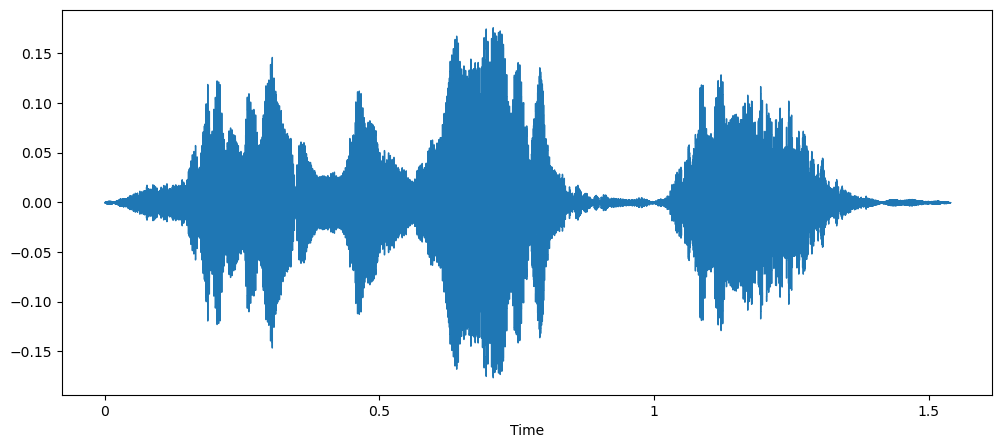

In [ ]:
# SHIFT
def shift(data, sr):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=4)


# SHIFTED AUDIO
x = shift(data, sr)  # Pass the sampling rate to the shift function
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

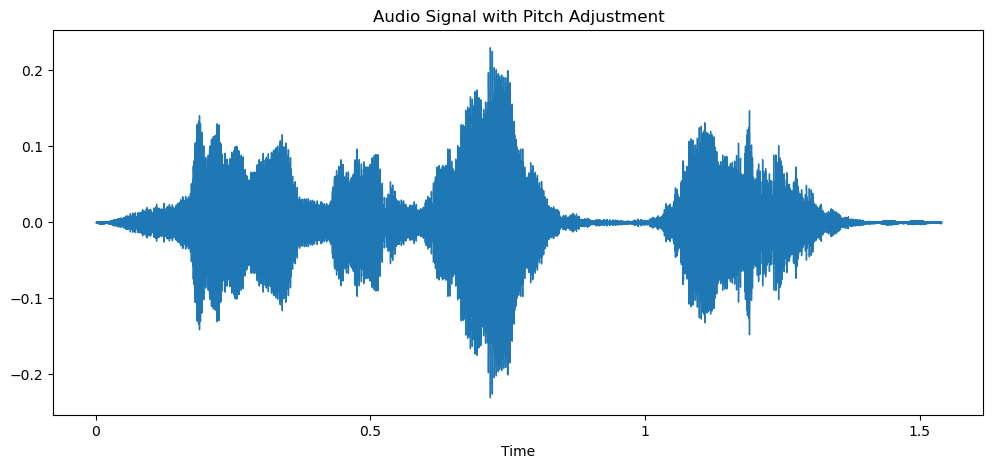

In [ ]:
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
plt.title("Audio Signal with Pitch")
ipd.Audio(x, rate=sr)

### Feature Extraction

In [ ]:
def calculate_zcr(data, frame_length, hop_length):
    return np.squeeze(librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length))

def calculate_rmse(data, frame_length=2048, hop_length=512):
    return np.squeeze(librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length))

def calculate_mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13, n_fft=frame_length, hop_length=hop_length)
    return np.ravel(mfccs.T) if flatten else np.squeeze(mfccs.T)

def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    features = np.hstack((
        calculate_zcr(data, frame_length, hop_length),
        calculate_rmse(data, frame_length, hop_length),
        calculate_mfcc(data, sr, frame_length, hop_length)
    ))
    return features

def get_features(path, duration=2.5, offset=0.6):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    aud = extract_features(data, sr)

    # Original and augmented audio feature extraction
    transformations = [
        data,  # original
        noise(data),  # added noise
        pitch(data, sr),  # pitch shifted
        noise(pitch(data, sr))  # noise added to pitch shifted
    ]

    feature_matrix = np.array([extract_features(transformed, sr) for transformed in transformations])

    return feature_matrix



In [ ]:
emotion_df

,Emotions,Path,source
0,angry,D:\UMBC\602\GP\CREMA-D\AudioWAV\1032_IWL_ANG_XX.wav,CREMA-D
1,angry,D:\UMBC\602\GP\CREMA-D\AudioWAV\1041_WSI_ANG_XX.wav,CREMA-D
2,angry,D:\UMBC\602\GP\CREMA-D\AudioWAV\1041_TAI_ANG_XX.wav,CREMA-D
3,angry,D:\UMBC\602\GP\CREMA-D\AudioWAV\1039_ITH_ANG_XX.wav,CREMA-D
4,angry,D:\UMBC\602\GP\TESS\tess_ds\YAF_angry\YAF_sail_angry.wav,TESS
...,...,...,...
6237,neutral,D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_witch_neutral.wav,TESS
6238,neutral,D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_yearn_neutral.wav,TESS
6239,neutral,D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_yes_neutral.wav,TESS
6240,neutral,D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_young_neutral.wav,TESS


In [ ]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  12


### Features Extraction

In [ ]:
print(emotion_df.columns)

Index(['Emotions', 'Path', 'source'], dtype='object')


In [ ]:
print(emotion_df['Emotions'].unique())

['angry' 'disgust' 'fear' 'happy' 'sad' 'neutral']


In [ ]:
print(emotion_df)

     Emotions                                                           Path  \
0       angry            D:\UMBC\602\GP\CREMA-D\AudioWAV\1032_IWL_ANG_XX.wav   
1       angry            D:\UMBC\602\GP\CREMA-D\AudioWAV\1041_WSI_ANG_XX.wav   
2       angry            D:\UMBC\602\GP\CREMA-D\AudioWAV\1041_TAI_ANG_XX.wav   
3       angry            D:\UMBC\602\GP\CREMA-D\AudioWAV\1039_ITH_ANG_XX.wav   
4       angry       D:\UMBC\602\GP\TESS\tess_ds\YAF_angry\YAF_sail_angry.wav   
...       ...                                                            ...   
6237  neutral  D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_witch_neutral.wav   
6238  neutral  D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_yearn_neutral.wav   
6239  neutral    D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_yes_neutral.wav   
6240  neutral  D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_young_neutral.wav   
6241  neutral  D:\UMBC\602\GP\TESS\tess_ds\YAF_neutral\YAF_youth_neutral.wav   

       source  
0     CREMA-D  
1     C

In [ ]:
print(emotion_df.iloc[0])

Emotions                                                  angry
Path        D:\UMBC\602\GP\CREMA-D\AudioWAV\1032_IWL_ANG_XX.wav
source                                                  CREMA-D
Name: 0, dtype: object


In [ ]:
print(emotion_df['Emotions'])

0         angry
1         angry
2         angry
3         angry
4         angry
         ...   
6237    neutral
6238    neutral
6239    neutral
6240    neutral
6241    neutral
Name: Emotions, Length: 6242, dtype: object


In [ ]:
data

array([-1.1267163e-05, -1.9048303e-04, -2.8634202e-04, ...,
        1.6369415e-04,  1.0550911e-04,  6.5897068e-05], dtype=float32)

In [ ]:
emotion_df.shape

(6242, 3)

In [ ]:
def extract_features_and_labels(emotion_df):
    X, Y = [], []

    # Start timing the operation
    start_time = time.time()

    # Use tqdm for progress tracking
    for path, emotion in tqdm(zip(emotion_df['Path'], emotion_df['Emotions']), total=len(emotion_df)):
        try:
            # Extract features for each audio file path
            features = get_features(path)
            for feature in features:
                X.append(feature)
                Y.append(emotion)
        except Exception as e:
            logging.error(f"Error processing file: {path}, {e}")

    # End timing the operation
    elapsed_time = time.time() - start_time
    print('Done')
    print(f'Time: {elapsed_time:.2f} seconds')

    return X, Y


X, Y = extract_features_and_labels(emotion_df)

100%|██████████████████████████████████████████████████████████████████████████████| 6242/6242 [08:42<00:00, 11.94it/s]

Done
Time: 522.81 seconds


In [ ]:
len(X), len(Y), emotion_df.Emotions.shape

(24968, 24968, (6242,))

### Handle Missing and Null Values

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.014160,0.020508,0.038574,0.047363,0.060059,0.071289,0.069336,0.066895,0.061523,0.056641,...,13.546376,40.066036,-5.257079,-5.832160,-6.293114,9.326446,-2.024701,-0.869612,5.770698,angry
1,0.109375,0.144531,0.165527,0.137207,0.093262,0.076172,0.071289,0.069824,0.065430,0.062500,...,22.859123,16.308289,4.017949,-3.947708,0.605311,5.265502,1.252695,-2.261212,-1.171454,angry
2,0.023438,0.046875,0.066895,0.075684,0.079102,0.073730,0.070801,0.071289,0.066406,0.061035,...,20.212532,34.513229,-10.628886,-10.702117,-2.353989,8.549912,-9.419196,-1.838661,-0.809090,angry
3,0.128906,0.167969,0.189941,0.146973,0.097656,0.077637,0.072754,0.071777,0.068359,0.063965,...,19.385352,11.851626,1.784996,-3.505071,-3.655230,3.175827,8.320022,3.261349,-0.015278,angry
4,0.021973,0.033203,0.044434,0.061523,0.129395,0.219238,0.323730,0.419922,0.461914,0.479980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry


In [ ]:
Emotions.shape

(24968, 1621)

In [ ]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.014160,0.020508,0.038574,0.047363,0.060059,0.071289,0.069336,0.066895,0.061523,0.056641,...,13.546376,40.066036,-5.257079,-5.832160,-6.293114,9.326446,-2.024701,-0.869612,5.770698,angry
1,0.109375,0.144531,0.165527,0.137207,0.093262,0.076172,0.071289,0.069824,0.065430,0.062500,...,22.859123,16.308289,4.017949,-3.947708,0.605311,5.265502,1.252695,-2.261212,-1.171454,angry
2,0.023438,0.046875,0.066895,0.075684,0.079102,0.073730,0.070801,0.071289,0.066406,0.061035,...,20.212532,34.513229,-10.628886,-10.702117,-2.353989,8.549912,-9.419196,-1.838661,-0.809090,angry
3,0.128906,0.167969,0.189941,0.146973,0.097656,0.077637,0.072754,0.071777,0.068359,0.063965,...,19.385352,11.851626,1.784996,-3.505071,-3.655230,3.175827,8.320022,3.261349,-0.015278,angry
4,0.021973,0.033203,0.044434,0.061523,0.129395,0.219238,0.323730,0.419922,0.461914,0.479980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry


In [ ]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
1616         True
1617         True
1618         True
1619         True
Emotions    False
Length: 1621, dtype: bool


In [ ]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
1616        False
1617        False
1618        False
1619        False
Emotions    False
Length: 1621, dtype: bool


(24968, 1621)

In [ ]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
1616        0
1617        0
1618        0
1619        0
Emotions    0
Length: 1621, dtype: int64

## Data Preparation for KNN and Random Forest Models

In [ ]:
x_val = Emotions.iloc[: ,:-1].values
y_emotions = Emotions['Emotions'].values

In [ ]:
# Initialize the encoder
label_encoder = LabelEncoder()

# Fit and transform labels to integers
Y_encoded = label_encoder.fit_transform(y_emotions)

print("Encoded labels:", Y_encoded)

Encoded labels: [0 0 0 ... 4 4 4]


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_val, Y_encoded, test_size=0.2, random_state=42)

In [ ]:
len(y_train)

19974

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19974, 1620), (19974,), (4994, 1620), (4994,))

### KNN Model with GridSearchCV

In [ ]:
# Setting the parameters by cross-validation
tuned_parameters = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

clf = GridSearchCV(
    KNeighborsClassifier(metric='manhattan'), tuned_parameters, cv=3,
    scoring='accuracy', verbose=3
)

clf.fit(x_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ....n_neighbors=3, weights=uniform;, score=0.581 total time=  43.6s
[CV 2/3] END ....n_neighbors=3, weights=uniform;, score=0.582 total time=  40.4s
[CV 3/3] END ....n_neighbors=3, weights=uniform;, score=0.581 total time=  38.2s
[CV 1/3] END ...n_neighbors=3, weights=distance;, score=0.699 total time=  29.4s
[CV 2/3] END ...n_neighbors=3, weights=distance;, score=0.693 total time=  31.4s
[CV 3/3] END ...n_neighbors=3, weights=distance;, score=0.694 total time=  32.0s
[CV 1/3] END ....n_neighbors=5, weights=uniform;, score=0.551 total time=  30.5s
[CV 2/3] END ....n_neighbors=5, weights=uniform;, score=0.559 total time=  29.3s
[CV 3/3] END ....n_neighbors=5, weights=uniform;, score=0.553 total time=  30.7s
[CV 1/3] END ...n_neighbors=5, weights=distance;, score=0.642 total time=  28.6s
[CV 2/3] END ...n_neighbors=5, weights=distance;, score=0.652 total time=  30.5s
[CV 3/3] END ...n_neighbors=5, weights=distance;,

In [ ]:
# Predicting the test set results
y_pred_clf= clf.best_estimator_.predict(x_test)

In [ ]:
# Calculate accuracy
accuracy_clf = accuracy_score(y_test, y_pred_clf)
print(f"Accuracy: {accuracy_clf*100:.2f}%")

# More detailed report using classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_clf))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_clf))

Accuracy: 79.32%
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       616
           1       0.82      0.72      0.76       632
           2       0.78      0.72      0.75       635
           3       0.83      0.81      0.82      1317
           4       0.77      0.83      0.80      1187
           5       0.69      0.82      0.74       607

    accuracy                           0.79      4994
   macro avg       0.80      0.79      0.79      4994
weighted avg       0.80      0.79      0.79      4994

Confusion Matrix:
[[ 504   18    6   58   25    5]
 [   9  452   18   37   52   64]
 [  17   24  459   47   31   57]
 [  27   15   41 1065  138   31]
 [   5   20   40   66  986   70]
 [   0   22   25   13   52  495]]


### Random Forest Model

In [ ]:
# Initialize the classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=20, min_samples_split=2, verbose=3)

# Train the classifier
rf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.5min finished


RandomForestClassifier(max_depth=20, random_state=42, verbose=3)

In [ ]:
y_pred_rf = rf.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [ ]:
accuracy_clf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_clf*100:.2f}%")

print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

# # Confusion Matrix
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred_rf))

Accuracy: 73.23%
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78       616
           1       0.78      0.60      0.68       632
           2       0.95      0.42      0.58       635
           3       0.71      0.85      0.77      1317
           4       0.65      0.87      0.75      1187
           5       0.74      0.70      0.72       607

    accuracy                           0.73      4994
   macro avg       0.79      0.69      0.71      4994
weighted avg       0.76      0.73      0.73      4994



### Data Preparation for CNN

In [ ]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
print(Y.shape)
X.shape

(24968, 6)


(24968, 1620)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19974, 1620), (19974, 6), (4994, 1620), (4994, 6))

In [ ]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19974, 1620), (19974, 6), (4994, 1620), (4994, 6))

In [ ]:
# Setup callbacks for early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

# Setup learning rate reduction
lr_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=0.00001
)

model_checkpoint = ModelCheckpoint('model.keras', save_best_only=True, monitor='val_accuracy', mode='auto', verbose=1)

## CNN Model

In [ ]:
#Reshape for CNN MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((19974, 1620, 1), (19974, 6), (4994, 1620, 1), (4994, 6))

In [ ]:
import tensorflow.keras.layers as L
import tensorflow as tf

# model definition with various layers
model = tf.keras.Sequential([
    # Reduce the number of filters in the convolutional layers
    L.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3, strides=2, padding='same'),

    # Remove one Conv1D layer to reduce complexity
    L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3, strides=2, padding='same'),
    L.Dropout(0.2),  # Maintain dropout for regularization

    # Flatten the output of the convolutional layers to feed into the dense layer
    L.Flatten(),

    # Reduce the number of neurons in the dense layer
    L.Dense(256, activation='relu'),
    L.BatchNormalization(),

    # Output layer: keep the same as the number of categories in the target classification
    L.Dense(6, activation='softmax')
])

# Compile the above model with optimizer, metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to see the model information
model.summary()


C:\Users\affuk\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1620, 256)           │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1620, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 810, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 810, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 810, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 405, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 405, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51840)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      13,271,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,374,854 (51.02 MB)

 Trainable params: 13,373,574 (51.02 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:
history=model.fit(x_traincnn, y_train, epochs=20, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stopping,lr_reduction,model_checkpoint])

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.3969 - loss: 1.7142
Epoch 1: val_accuracy improved from -inf to 0.26292, saving model to model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 164s 516ms/step - accuracy: 0.3971 - loss: 1.7133 - val_accuracy: 0.2629 - val_loss: 109.2302 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.5410 - loss: 1.1939
Epoch 2: val_accuracy improved from 0.26292 to 0.48218, saving model to model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 164s 523ms/step - accuracy: 0.5411 - loss: 1.1938 - val_accuracy: 0.4822 - val_loss: 1.8422 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.6087 - loss: 1.0350
Epoch 3: val_accuracy did not improve from 0.48218
313/313 ━━━━━━━━━━━━━━━━━━━━ 182s 582ms/step - accuracy: 0.6087 - loss: 1.0350 - val_accuracy: 0.4616 - val_loss: 1.5984 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.6636 - loss: 0.

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9425 - loss: 0.1892
Accuracy of our model on test data :  94.55346465110779 %


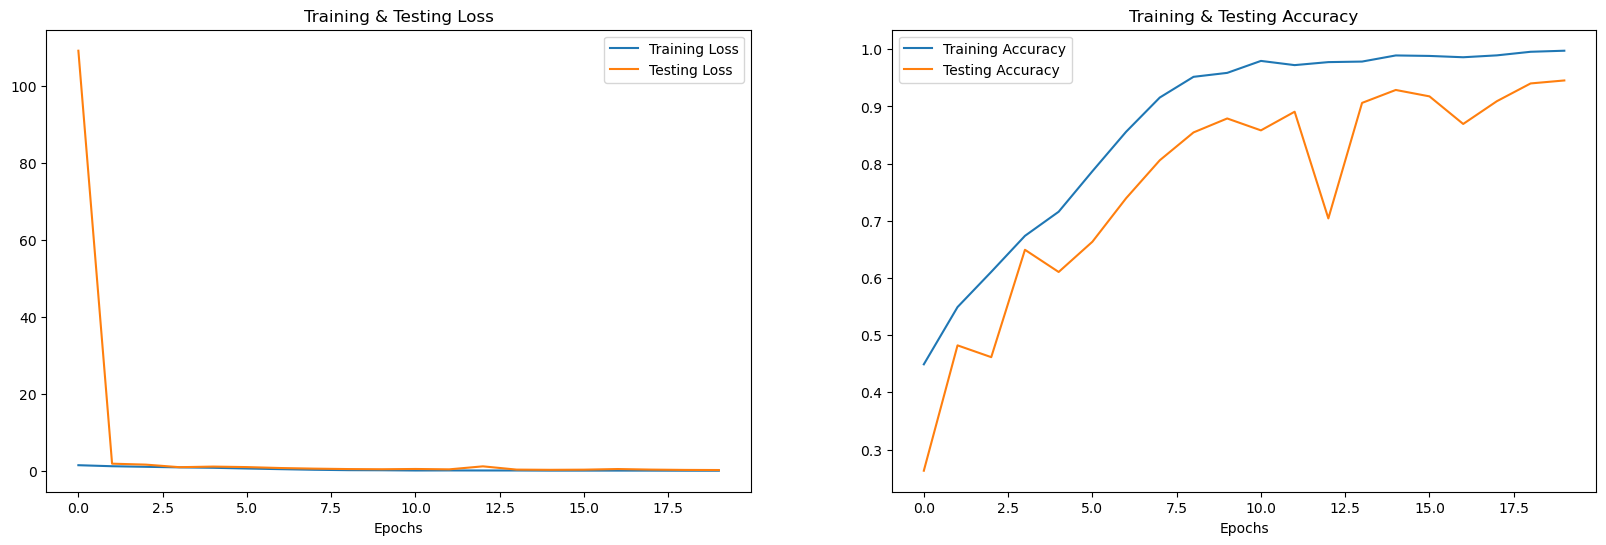

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

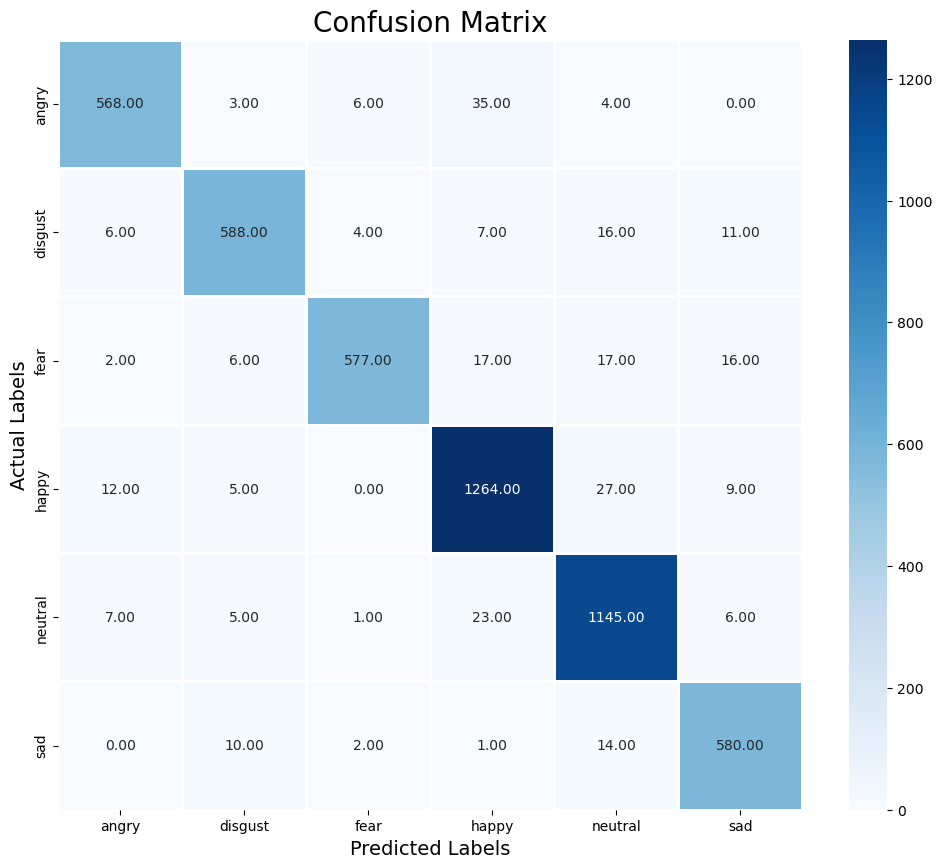

              precision    recall  f1-score   support

       angry       0.95      0.92      0.94       616
     disgust       0.95      0.93      0.94       632
        fear       0.98      0.91      0.94       635
       happy       0.94      0.96      0.95      1317
     neutral       0.94      0.96      0.95      1187
         sad       0.93      0.96      0.94       607

    accuracy                           0.95      4994
   macro avg       0.95      0.94      0.94      4994
weighted avg       0.95      0.95      0.95      4994



In [ ]:
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

# Model Comparision

# Random Forest

Accuracy: 73.23%   
Precision (Macro Average): 0.79  
Recall (Macro Average): 0.69  
F1 Score (Macro Average): 0.71

## KNN Model

Accuracy: 79.32%   
Precision (Macro Average): 0.80    
Recall (Macro Average): 0.79    
F1 Score (Macro Average): 0.79    

## CNN Model
Accuracy: 95%    
Precision (Macro Average): 0.95  
Recall (Macro Average): 0.94  
F1 Score (Macro Average): 0.94  

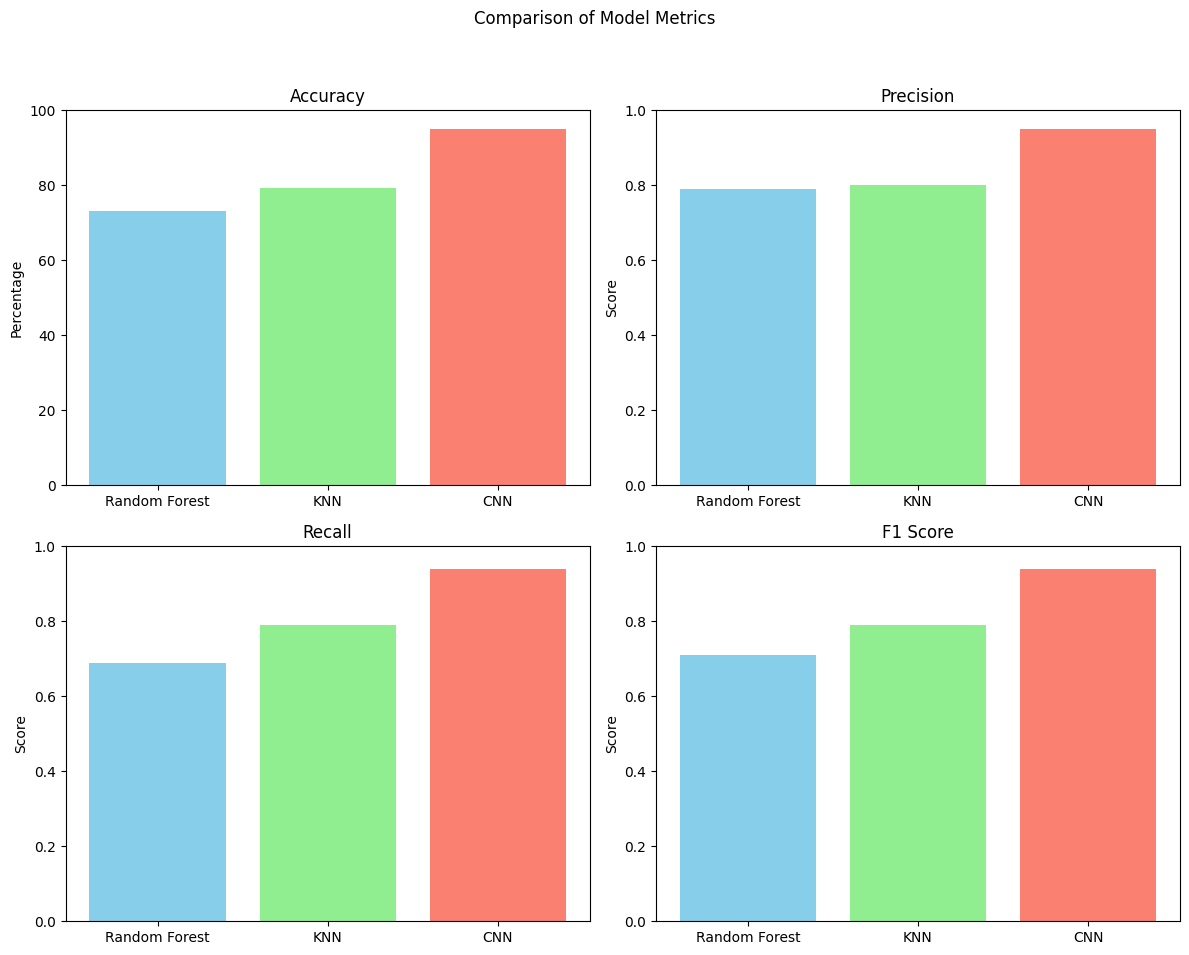

In [2]:
# Data from the classification reports for each model
models = ['Random Forest', 'KNN', 'CNN']
accuracy = [73.23, 79.32, 95]
precision = [0.79, 0.80, 0.95]
recall = [0.69, 0.79, 0.94]
f1_score = [0.71, 0.79, 0.94]

# Creating subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Comparison of Model Metrics')

# Custom colors for the plots
colors = ['skyblue', 'lightgreen', 'salmon']

# Plotting accuracy
ax[0, 0].bar(models, accuracy, color=colors)
ax[0, 0].set_title('Accuracy')
ax[0, 0].set_ylabel('Percentage')
ax[0, 0].set_ylim([0, 100])

# Plotting precision
ax[0, 1].bar(models, precision, color=colors)
ax[0, 1].set_title('Precision')
ax[0, 1].set_ylabel('Score')
ax[0, 1].set_ylim([0, 1])

# Plotting recall
ax[1, 0].bar(models, recall, color=colors)
ax[1, 0].set_title('Recall')
ax[1, 0].set_ylabel('Score')
ax[1, 0].set_ylim([0, 1])

# Plotting F1-score
ax[1, 1].bar(models, f1_score, color=colors)
ax[1, 1].set_title('F1 Score')
ax[1, 1].set_ylabel('Score')
ax[1, 1].set_ylim([0, 1])

# Show plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Predicting on Test data

In [ ]:
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step


In [ ]:
df0

,Predicted Labels,Actual Labels
0,neutral,neutral
1,disgust,disgust
2,neutral,neutral
3,fear,fear
4,disgust,sad
...,...,...
4989,disgust,disgust
4990,sad,sad
4991,fear,fear
4992,happy,happy
